In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import gudhi
import numpy as np
import random

In [2]:
def create_s_w_network(n,k,p):
    return nx.watts_strogatz_graph(n, k, p)

def get_access_times_for_node(G,start_node,T):
    #G: network
    #T: number of iterations
    #start_node: node in which cascade starts
    
    n = G.number_of_nodes()
        
    x0 = np.zeros((n))
    x0[start_node] = 1;
    A = nx.adjacency_matrix(G).todense()


    # run dynamics
    x = np.zeros((T,n))
    x[0] = x0
    for t in range(T-1):
        x[t+1] = np.dot(A,x[t].T)


    access_times_for_cascade = np.array([np.where(x.T[i])[0][0]for i in range(n)])
    return access_times_for_cascade

In [3]:
cmap = 'jet'
start_node = 25
time = 100
n = 100
k = 4
probs = [0,0.01,0.02,0.03,0.04,0.05] 

G = create_s_w_network(n,k,p = .04)
#nx.adjacency_matrix(G).todense()

### Access times for 6 watts-strogatz networks with varying p=[0,0.1,0.2,0.3,0.4,0.5]

In [4]:
networks=[]
access_times=[]
all_access_times_nodes=[]
simplex_trees=[]
diags=[]

for i,p in enumerate(probs):
        
    #create networks of different p
    networks.append(create_s_w_network(n,k,p))
    pos = nx.circular_layout(networks[i])
    colors = np.arange(n)
    access_time_nodes = np.zeros((n,n))
    
    #compute access times of the cascade starting at node "start_node"
    access_times.append(get_access_times_for_node(networks[i],start_node,time))#compute access times for every node
                                                                             #for each network
    
    # run a cascade started at each individual node and get access times for each cascade
    for start_node in range(n):
        access_time_nodes[start_node] = get_access_times_for_node(networks[i],start_node,time)
    all_access_times_nodes.append(access_time_nodes)
    
    #compute PH
    point_cloud = all_access_times_nodes[i] / n
    rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=10)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    
    simplex_trees.append(simplex_tree)
    
    diag = simplex_trees[i].persistence(min_persistence=0.0)
    diags.append(diag)
  

In [5]:
def draw_activations_on_ring_net(prob,network,pos,node_color,ax,nodelist):              
    #draw networks
    node_plot=nx.draw_networkx_nodes(network,pos=pos,node_size=20,node_color=node_color,cmap=cmap,ax=ax)
    nx.draw_networkx_edges(network,pos=pos,edge_size=1,alpha=.5,ax=ax)
    nx.draw_networkx_nodes(network,nodelist=nodelist,pos=pos,node_size=60,node_color='black',alpha=.5,ax=ax)
    ax.set_title('n=%d, k=%d,p=%.2f'%(n,k,prob),fontsize=12)
    return

def draw_activations_matrix(prob,access_times_nodes,ax):              
    #show access times matrix
    # access_times[i,j] denotes how long a cascades started at i takes to get to j
    ax.imshow(access_times_nodes,cmap=cmap)
    ax.set_title('n=%d, k=%d,p=%.2f'%(n,k,prob),fontsize=12)
    ax.set_xlabel('base node', fontsize=12)
    ax.set_ylabel('terminal node',fontsize=12)
    return


def make_small_world_figure(probs,networks,pos,all_access_times_nodes,start_node,diags):
    
    fig,ax = plt.subplots(3,len(probs),figsize=(16,8))
    for i,p in enumerate(probs):

        draw_activations_on_ring_net(p,network=networks[i],
                                     pos=pos,
                                     node_color=all_access_times_nodes[i][start_node],
                                     ax=ax[0][i],
                                     nodelist=[start_node]
                                    )

        draw_activations_matrix(p,access_times_nodes=all_access_times_nodes[i],
                                ax=ax[1][i])


        gudhi.plot_persistence_diagram(diags[i],axes=ax[2][i])

    plt.tight_layout()
    #plt.colorbar(node_plot,ax=ax[0])
    
    return    

TypeError: plot_persistence_diagram() got an unexpected keyword argument 'axes'

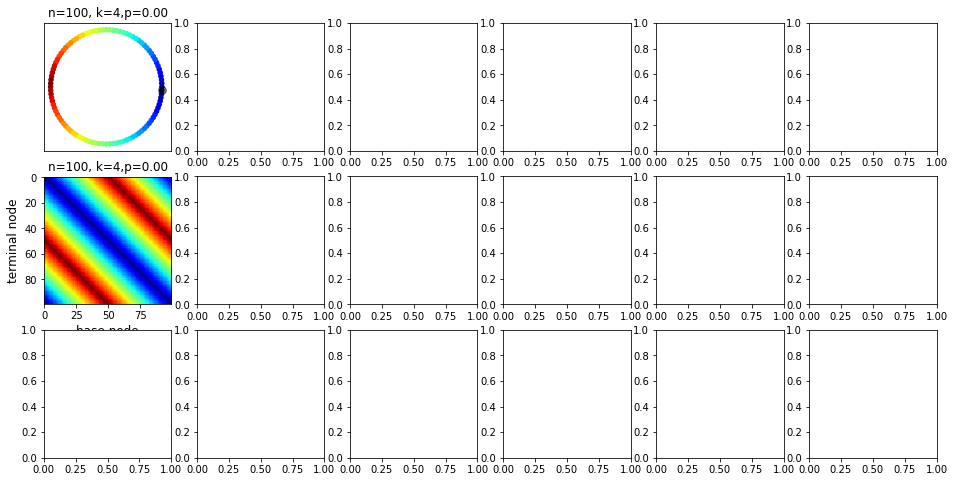

In [6]:
make_small_world_figure(probs,networks,pos,all_access_times_nodes,start_node,diags)

# Leaky Integrate and Fire class

In [7]:
class LIF():
    
    def __init__(self, _I, gl, Cm, El , thresh, spike_val):
    
        self.current = _I
        self.conductance = gl
        self.capacitance = Cm
        self.membr_potential = El
        
        self.spiking_threshold = thresh
        self.spikes = 0
        self.spike_value = spike_val
    
    def V_values(self, T, dt, interval): 
        #function for iterating the model and spitting out the change in membrane potential

        #T = total simulation length [s]
        #dt = step size [s]
        #interval = time interval for the applied current-should be between 0 and T/dt
    
        time    =   np.arange(0, T+dt, dt)      # step values [s]
    
        # VOLTAGE
        V       =   np.zeros(len(time))         # array for saving Voltage history
        V[0]    =   self.membr_potential                        # set initial to resting potential
        
        #CURRENT
        I = self.I_values(time,interval)
        
        ######### Simulation
        for i in range(1, len(time)):
            # use "I - V/R = C * dV/dT" to get this equation
            dV =  (I[i] - self.conductance*(V[i-1]-self.membr_potential))/self.capacitance
            V[i] = V[i-1] + dV*dt

            # in case we exceed threshold
            if V[i] > self.spiking_threshold:
                V[i-1] = self.spike_value   # set the last step to spike value
                V[i] = self.membr_potential       # current step is resting membrane potential
                self.spikes += 1     # count spike

        return V
    
    def I_values(self, time, interval): 
        #function calculating the applied current
        
        I = np.zeros(len(time))
        I[interval[0]:interval[1]] = self.current
        return I
    
    def plotting(self, I, V, time):
        ## Plotting
        fig = plt.figure("Leaky Integrate-and-Fire Neuron", figsize=(14, 7))
        ax = fig.add_subplot(111)
        plt.title("Leaky Integrate-and-Fire Neuron Simulation")
        fig.subplots_adjust(left=0.1, bottom=0.32)

        # plot lines
        line = plt.plot(time, V, label="Membrane Potential")[0]
        line2 = plt.plot(time, I, label="Applied Current")[0]
    
        # add legend
        plt.legend(loc="upper right")

        # add axis labels
        plt.ylabel("Potential [V]/ Current [A]")
        plt.xlabel("Time [s]")
        
        return

## Sample Simulation

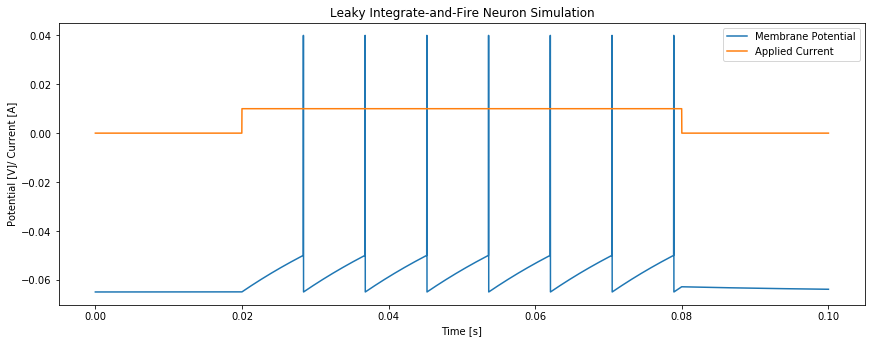

In [8]:
##initial experiment based parameters
I_inital = 0.01
gl_inital = 0.16
Cm_inital = 0.0049

##initalize the LIF class
leaky_IandF_neuron = LIF(_I = I_inital,  # constant applied current 
                         gl = gl_inital, # conductance
                         Cm = Cm_inital, # capacitance
                         El = -0.065,    # membrane potential
                         thresh = -0.05, # spiking threshold
                         spike_val=0.04) # spiking value

##initial time based parameters
T = 0.100
dt = 0.00002
time = np.arange(0, T+dt, dt)
interval = [1000,4000]

##run the simulations
V = leaky_IandF_neuron.V_values(T = T,              # total simulation length          
                                dt= dt,             # step size
                                interval = interval)# list of length 2 indicating the time interval current applied

I = leaky_IandF_neuron.I_values(time, interval)

#plot
leaky_IandF_neuron.plotting(I,V,time)

# Kuramoto Oscillator Class

In [9]:
class kuramoto_oscillator:## main class of objects for the model
    ###############################################################
    
    ## omega(internal frequency): One of the three options are available, 'uniform', 'normal','gamma'                                
    
    ## theta(inital state of the oscillator): 'random' 
    
    ################################################################
    
    def __init__(self,omega, theta):
        
        if theta == 'random': self.state = 2 * np.pi * np.random.rand(1,1)
                    
        if omega == 'uniform': self.angular_velocity = 1 + np.random.uniform(-0.05,0.05)
        elif omega == 'normal': self.angular_velocity = np.random.normal(1,0.05)
        elif omega == 'gamma': self.angular_velocity =  1 + random.choice((-1,+1)) * np.random.gamma(1,0.05) 
            

class kuramoto_model_network: ##Network Object with oscillator objects as nodes- Utilizes NetworkX
    
    def __init__(self, oscillators):
        
        ##initialize a network with oscillators
        
        ##attributes of the kuramato model network:
        
        ## oscillators, size of the network
        
        self.nodes = oscillators
        self.size = len(oscillators)
        
    def make_network(self, graph_type = 'complete', plot=True, **kwargs):
        
        #####################################################
        ## we use networkx to create a network with each node 
        ## has an attribute of 'theta' as the state of the cell
        ## and 'omega' distribution
        #####################################################
        
        ### if plot=True: plots the network
        
        ### graph_type: indicates the type of the graph to be 
        #   initialized among 'complete', 'random', 'barabasi' and 'configuration'
        
        ### if graph_type = ' random' or 'barabasi', additional argument 'prob=' is needed
        
        ### if graph type = 'configuration', additional argument 'degree_sequence=' is needed

        # initialize the networkx graph
        if graph_type == 'complete': 
            G = nx.generators.classic.complete_graph(self.size)
        elif graph_type == 'random': 
            G = nx.gnp_random_graph(self.size, kwargs['prob'])
        elif graph_type == 'barabasi': 
            G = nx.barabasi_albert_graph(self.size,kwargs['prob'])
        elif graph_type == 'configuration': 
            G = nx.configuration_model(deg_sequence= kwargs['degree_sequence'])
            
        # get the adjacency matrix   
        A = nx.adjacency_matrix(G)
        self.coupling_matrix = np.array(A.todense())
        
        #define the node attributes
        for i in range(int(self.size)):
            G.nodes[i]['theta'] = self.nodes[i].state
            G.nodes[i]['omega'] = self.nodes[i].angular_velocity
            
        #plot    
        if plot:
            nx.draw_spring(G, width = 0.08, node_size = 20)
        return(G)

        
    def update_nodes(self, G, Dt, interaction = 'two_way', **kwargs):
        
        ## function to run the simulation
        ## Arguments: 
        ##           G:  network
        ##           Dt: step size
        ##           interaction: 'two_way', 'three_way' or 'biharmonic'
        ##           if three_way, 'couplin_ijk' argument should be provided for the three way couplin matrix
        ##           if biharmonic, 'k1' and 'k2' arguments should be provided
        ##           for more info, check out the papers
        
        N = self.size
        
        
        #### Simple pairwise Kuramoto coupling on the network
        #    coupling is among the neighbors of the node i
        if interaction == 'two_way':
            for i in G.nodes:
                theta_i = G.nodes[i]['theta']
                S = sum([self.coupling_matrix[i][j] * np.sin(G.nodes[j]['theta'] - theta_i) for j in G.neighbors(i)])
                G.nodes[i]['theta'] = theta_i + (G.nodes[i]['omega'] + S/G.degree(i)) * Dt
        
        #### Three-way nonlinear coupling according to the paper
        #   'Bifurcation analysis and structural stability of simplicial oscillator populations'
        elif interaction == 'three_way':
            for i in G.nodes:
                theta_i = G.nodes[i]['theta']
                for j in G.nodes:
                    theta_j = G.nodes[j]['theta']
                    S = sum([kwargs['coupling_ijk'] * np.sin(theta_j + G.nodes[k]['theta'] - 2*theta_i) for k in G.nodes])
                G.nodes[i]['theta'] = theta_i + (G.nodes[i]['omega'] + S/(N**2)) * Dt
                
        #### Biharmonic interaction according to the paper
        #   'Synchronous dynamics in the Kuramoto model with biharmonic interaction and bimodal frequency distribution'
        elif interaction == 'biharmonic':
            theta_i = G.nodes[i]['theta']
            S1 = sum([np.sin(G.nodes[j]['theta']-theta_i) for j in G.nodes])
            S2 = sum([np.sin(2*(G.nodes[j]['theta']-theta_i)) for j in G.nodes])
            G.nodes[i]['theta'] = theta_i + (G.nodes[i]['omega'] + (kwargs['k1']/N)*S1 + (kwargs['k2']/N)*S2)*Dt
                
        #elif interaction == 'simplicial':
            
            
                
    def r_of_t(self,G):
        
        ## function that computes the phase coherence at every iteration
        
        n = self.size
        sync = 0
        
        for i in range(n):
            sync = sync + (complex(np.cos(G.nodes[i]['theta']),np.sin(G.nodes[i]['theta'])))
            
        synchrony = abs((1/n)*sync)
        return(synchrony)
    
    def phase_coherence(self, G, time, dt, plot = True, threshold = True, **kwargs):
        
        ## function that computes the phase coherence and graphs it after 'time' iteration
        
        ## G: network
        ## time: number of steps the system is going to be iterated
        ## dt: size of the steps the system is going to be iterated
        ## if plot=True: plots the phase coherence
        ## if threshold=True: a red bar shows up in the figure to indicate the threshold where the system is 'synchronous'
        ##               aditional argument 'value' between 0 and 1 is needed
        
        ## Returns: list of values of the phase coherences of the system at each time iteration
        
        phase_coherence_over_time = []
        for t in range(time):
            self.update_nodes(G,dt, interaction = 'two_way')
            k = self.r_of_t(G)
            phase_coherence_over_time.append(k)
            
            
        if plot == True:
            
            
            thres = 0
            if threshold == True:
                for t,i in enumerate(phase_coherence_over_time):
                    if i > kwargs['value']: thres=t; break
                       
            fig,ax = plt.subplots(1,1,figsize=(8,8))
            x = np.linspace(0,1000,1000)
            ax.plot(phase_coherence_over_time)
            ax.set_title("r_{t} vs time",fontsize=20)
            ax.set_ylabel('phase_coherence',fontsize=15)
            ax.set_xlabel('time',fontsize=15)
            ax.tick_params(axis='both', which='major', labelsize=15)
            
            if not thres == 0:
                ax.axvline(thres,color='red')
                ax.text(thres, kwargs['value'] ,'%s'%thres, fontsize=15)
                
        self.time = 0
        
        return(phase_coherence_over_time)
    
    
######################################################
######### helper functions ############################
######################################################


def create_osc(N, omega, theta):
    
    ## handy function that creates the oscillators
    
    o = []# list containing the oscillator objects
    
    for i in range(N): 
        o.append(kuramoto_oscillator(omega, theta))
        
    return(o)

def create_net(oscillators, type_graph, prob=bool, plot=bool, degree_sequence=bool):
    
    ### handy function that creates the networks
    
    M = kuramoto_model_network(oscillators) ## returns kuramato model network object

    N = M.make_network(graph_type=type_graph,prob=False, plot=True)
    
    return(M,N)

def edgewise_synchronization(number_of_rois, name,data, time):
    
    ## function that computes the edgewise synchrony of the ROIS from the calcium dynamics
    
    n = number_of_rois                               
    C = np.zeros((n,n))
    
    for i in range(n):
        for j in range(i):
            
            k = 0
            for t in range(int(time)):
                k = k + complex(np.cos(data['%s'%name][i][t]-data['%s'%name][j][t]),np.sin(data['%s'%name][i][t]-data['%s'%name][j][t]))
                
            C[j][i] = abs(k)/int(time)
            C[i][j] = abs(k)/int(time)
            
    return(C)

# Sample Initialization

## 1) Create 50 Kuramoto Oscillators with uniform angular velocity distribution and a random initial state

In [10]:
oscillators = create_osc(50,        # number of oscillators
                         'uniform', # dist. of the internal freq. of the osc.- can be 'uniform', 'normal' or 'gamma'
                         'random')  # initial state of the oscillators can only be 'random'

## 2) Create Networkx complete graphs and network objects¶

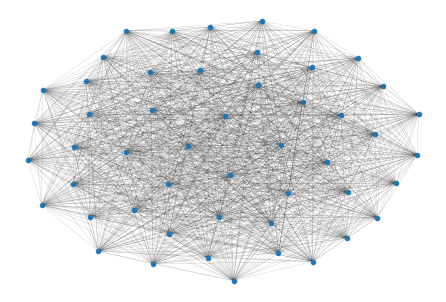

In [11]:
M, N = create_net(oscillators,                               ## oscillator objects
               'complete',                                   ## on a complete network
               prob=False,                                   ## we don't need this since it's a complete network
               plot= True,                                   ## plots
               degree_sequence=False )                       ## we don't need this since it's a complete network

## 3) Plot phase coherence over time 1000 steps with step size 0.01

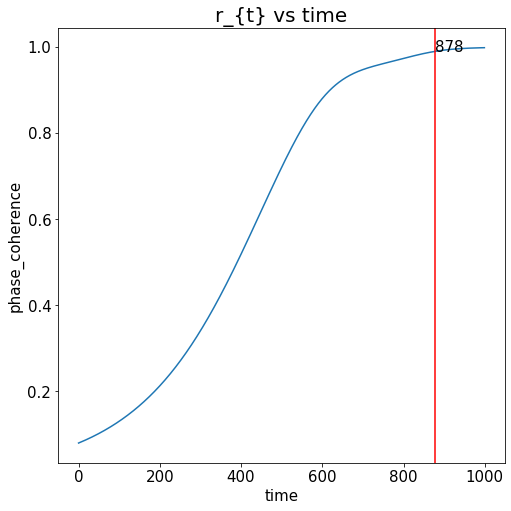

In [12]:
phase = M.phase_coherence(N,            #Kuramoto Network object 
                        1000,           #number of iterations
                        0.01,           #step size
                        plot=True,      #plots
                        threshold=True, #puts the red vertical bar on the graph for the threshold at the 'value'
                        value=0.99)      #threshold value